In [19]:
import tensorflow as tf
import numpy as np

training_examples = 10000    # 训练数据个数
testing_examples = 1000      # 测试数据个数
sample_gap = 0.01            # sin函数的采样率

timesteps = 20    # 每个训练样本的长度;即待预测的数据是由前timestep个数据得来的
batch_size = 64   # 每次训练的数据的大小
lstm_size = 20    # 隐藏层中的单元数量;timesteps是每一个单元中时间状态的数量
input_size = 1    # 一个隐藏层单元的输入的维度
output_size = 1   # 模型输出层的单元数量
hidden_layers = 2 # 隐藏层的层数

In [63]:
"""定义模型"""
class LSTM():
    def __init__(self, timesteps, batch_size, lstm_size, input_size, output_size, hidden_layers):
        # 模型超参数
        self.timesteps = timesteps
        self.batch_size = batch_size
        self.lstm_size = lstm_size
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        
        # 模型输入
        self.input_x = tf.placeholder(tf.float32, [None, timesteps, input_size], name='input_x')
        self.input_y = tf.placeholder(tf.float32, [None, input_size], name='input_y')
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')    # 隐藏层单元存活的概率
        
        # 模型结构
        self.lstm_cell()
        self.add_hidden_layer()
        self.add_output_layer()    
        self.cost = tf.losses.mean_squared_error(self.input_y, self.outputs)  # 损失函数为均方差函数
        self.train_op = tf.train.AdamOptimizer().minimize(self.cost)          # 优化器为Adam
     
    def lstm_cell(self):
        return tf.contrib.rnn.BasicLSTMCell(self.lstm_size)
    
    def add_hidden_layer(self):
        lstm = tf.contrib.rnn.BasicLSTMCell(self.lstm_size)    # 定义隐藏层
        drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=self.keep_prob)    # 在隐藏层上添加dropout
        self.hidden_layer = tf.contrib.rnn.MultiRNNCell([self.lstm_cell() for i in range(self.hidden_layers)])    # 堆叠两层隐藏层
        self.hidden_layer_outputs, self.hidden_layer_final_state = tf.nn.dynamic_rnn(self.hidden_layer, self.input_x, dtype=tf.float32)  # 隐藏层输出
        # 每一个隐藏层的outputs的维度为[batch_size, timesteps, lstm_size]，final_state的维度为[2, batch_size, lstm_size]
        self.hidden_layer_outputs = self.hidden_layer_outputs[:,-1,:]  # 当前的输出是最后一个时间步长的数据,维度为batch_size * lstm_size
    
    def add_output_layer(self):    # 添加全连接层,输出维度为1;sin()的输出为[-1,1],故激活函数选择tanh
        self.outputs = tf.contrib.layers.fully_connected(self.hidden_layer_outputs, self.output_size, activation_fn=tf.tanh)               
            

In [22]:
"""生成模型的输入特征和标签"""
def generate_data(seq):
    X = []    # 输入数据:n * timesteps
    y = []    # 输出数据:n * 1
 
    # 每timesteps+1个数为一组，前timesteps个数为特征，第timesteps个数为标签
    for i in range(len(seq) - timesteps - 1):
        X.append(seq[i : i + timesteps])   
        y.append(seq[i + timesteps]) 

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [21]:
"""生成训练集和测试集"""
# 确定数据范围
start = training_examples * sample_gap     # 10000*0.01=100
end = start + testing_examples * sample_gap   # 100+1000*0.01=110

# 生成数据集
train_x, train_y = generate_data( np.sin( np.linspace(0, start, training_examples) ) ) 
# np.linspace(0, start, training_examples)：在0到start中等间隔地生成training_examples个数
test_x, test_y = generate_data( np.sin( np.linspace(start, end, testing_examples) ) )

print(np.shape(train_x),np.shape(train_y),np.shape(test_x),np.shape(test_y))

(9979, 20) (9979,) (979, 20) (979,)


In [23]:
"""获取一个batch_size大小的数据"""
def get_batches(X, y, size = batch_size):
    for i in range(0, len(X), size):
        begin_i = i
        end_i = i + size if (i + size) < len(X) else len(X)

        yield X[begin_i:end_i,:], y[begin_i:end_i]
        
batch = get_batches(train_x,train_y)
batch_x,batch_y = next(batch)
print(np.shape(batch_x),np.shape(batch_y))

(64, 20) (64,)


In [74]:
"""训练模型"""
epochs = 100
keep_prob = 0.9

with tf.variable_scope("jnn", reuse=None):    # 解决名字冲突问题
    lstm_model = LSTM(timesteps, batch_size, lstm_size, input_size, output_size, hidden_layers)
session = tf.Session()

with session.as_default() as sess:
    tf.global_variables_initializer().run()    # 变量必须显示地初始化
    
    for i in range(1, epochs+1):
        for xs, ys in get_batches(train_x, train_y, batch_size): 
            feed_dict = {lstm_model.input_x:xs[:,:,None], lstm_model.input_y:ys[:,None], lstm_model.keep_prob:keep_prob}
            # xs[:,:,None] 表示增加一个维度，为了对应输入
            loss, _ = sess.run([lstm_model.cost, lstm_model.train_op], feed_dict=feed_dict)
            
        if i % 10 == 0:
            print('Epochs:{}/{}'.format(i, epochs), 'Train loss: {:.8f}'.format(loss))

Epochs:10/100 Train loss: 0.01902139
Epochs:20/100 Train loss: 0.00105662
Epochs:30/100 Train loss: 0.00021964
Epochs:40/100 Train loss: 0.00016553
Epochs:50/100 Train loss: 0.00012998
Epochs:60/100 Train loss: 0.00011564
Epochs:70/100 Train loss: 0.00011259
Epochs:80/100 Train loss: 0.00019557
Epochs:90/100 Train loss: 0.00016811
Epochs:100/100 Train loss: 0.00000473


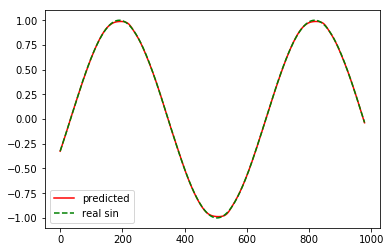

In [75]:
"""测试模型"""
import matplotlib.pyplot as plt
%matplotlib inline

with session.as_default() as sess:
    feed_dict = {lstm_model.input_x:test_x[:,:,None], lstm_model.keep_prob:1.0}
    results = sess.run(lstm_model.outputs, feed_dict=feed_dict)
    plt.plot(results,'r', label='predicted')
    plt.plot(test_y, 'g--', label='real sin')
    plt.legend()
    plt.show()

In [21]:
"""计算模型精度"""
arr_results = np.array(results + 1).flatten()  # +1使结果全为正数
arr_label = np.array(test_y + 1).flatten()
error = np.abs(arr_results - arr_label)
print("Total_error: {:.5f}".format(np.sum(error)))
accuracy = (arr_label - error) / arr_label
print(accuracy)
mean_accuracy = np.mean(accuracy)    # 精度丢失？？？
print("Test accuracy: {:.5f}".format(mean_accuracy))

Total_error: 13.33709
[  9.89792526e-01   9.90078926e-01   9.90362227e-01   9.90642190e-01
   9.90918159e-01   9.91189957e-01   9.91456866e-01   9.91718709e-01
   9.91975009e-01   9.92225528e-01   9.92469668e-01   9.92707312e-01
   9.92938280e-01   9.93161798e-01   9.93378043e-01   9.93586540e-01
   9.93786931e-01   9.93979275e-01   9.94163215e-01   9.94338393e-01
   9.94504809e-01   9.94662344e-01   9.94810641e-01   9.94949698e-01
   9.95079279e-01   9.95199263e-01   9.95309711e-01   9.95410442e-01
   9.95501220e-01   9.95582223e-01   9.95653272e-01   9.95714366e-01
   9.95765507e-01   9.95806634e-01   9.95837867e-01   9.95859087e-01
   9.95870352e-01   9.95871782e-01   9.95863438e-01   9.95845318e-01
   9.95817542e-01   9.95780289e-01   9.95733440e-01   9.95677352e-01
   9.95612144e-01   9.95537877e-01   9.95454729e-01   9.95362878e-01
   9.95262444e-01   9.95153844e-01   9.95037019e-01   9.94912386e-01
   9.94780064e-01   9.94640350e-01   9.94493484e-01   9.94339824e-01
   9.9417936